In [257]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels
import linearmodels
import matplotlib as plt
import xlrd
import scipy
from scipy.stats import sem, t
from scipy import mean
import os
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
import pandas_profiling
from linearmodels.panel import PanelOLS
import random

%matplotlib inline

In [258]:
# read data file, convert to csv
data = pd.read_excel('data/fpds_rates.xlsx')

In [259]:
data.head()

,AgencyWide,department_id,department_name,contracting_agency_id,contracting_agency_name,FiscalYear,TotalActions,TotalDollars,CompetedActions,CompetedDollars,...,HubZoneActions,HubZoneDollars,HubZoneRate,OtsbActions,OtsbDollars,OtsbRate,EligibleActions,EligibleDollars,SB+OTSB,OneBidRate+EffCompRate
0,1,300,LIBRARY OF CONGRESS,NaN,NaN,2014,24,0.0,24,0.0,...,0.0,0.0,NaN,21.0,0.0,NaN,24.0,0.0,NaN,NaN
1,1,300,LIBRARY OF CONGRESS,NaN,NaN,2015,10,0.0,10,0.0,...,0.0,0.0,NaN,6.0,0.0,NaN,10.0,0.0,NaN,NaN
2,1,300,LIBRARY OF CONGRESS,NaN,NaN,2016,7,0.0,6,0.0,...,0.0,0.0,NaN,4.0,0.0,NaN,7.0,0.0,NaN,NaN
3,1,300,LIBRARY OF CONGRESS,NaN,NaN,2017,18,0.0,18,0.0,...,1.0,0.0,NaN,7.0,0.0,NaN,18.0,0.0,NaN,NaN
4,0,300,LIBRARY OF CONGRESS,300,LIBRARY OF CONGRESS,2014,24,0.0,24,0.0,...,0.0,0.0,NaN,21.0,0.0,NaN,24.0,0.0,NaN,NaN


In [260]:
data.columns

Index(['AgencyWide', 'department_id', 'department_name',
       'contracting_agency_id', 'contracting_agency_name', 'FiscalYear',
       'TotalActions', 'TotalDollars', 'CompetedActions', 'CompetedDollars',
       'CompRate', 'NotCompetedActions', 'NotCompetedDollars', 'NotCompRate',
       'OneBidActions', 'OneBidDollars', 'OneBidRate', 'EffCompActions',
       'EffCompDollars', 'EffCompRate', 'SbActions', 'SbDollars', 'SbUtilRate',
       'SdbActions', 'SdbDollars', 'SdbRate', 'WosbActions', 'WosbDollars',
       'WosbRate', 'SdvosbcActions', 'SdvosbcDollars', 'SdvosbcRate',
       'HubZoneActions', 'HubZoneDollars', 'HubZoneRate', 'OtsbActions',
       'OtsbDollars', 'OtsbRate', 'EligibleActions', 'EligibleDollars',
       'SB+OTSB', 'OneBidRate+EffCompRate'],
      dtype='object')

In [261]:
data.shape

(1171, 42)

In [262]:
data['unique_name'] = data['department_name'] + '-' + data['contracting_agency_name']
data['unique_name'] = data['unique_name'].fillna('agency wide')

# Intro
 
Here we're trying to recreate a fixed effects panel regression written in the proprietary econometric software EViews. We only have the summary output of that model, which is specified as:

`EffCompRate ~ C + NotCompRate(-1) + OneBidRate + SdbRate`

These variables are defined as follows:
 - **EffCompRate:** Total Competed Dollars with 2 or more bids / Total Competed Dollars
 - **NotCompRate:** Total Not Competed Dollars / Total Obligations
 - **OneBidRate:** Total Competed Dollars with only 1 bid / Total Competed Dollars
 - **SdbRate:** Total Small Disadvantaged Business Dollars / Total Small Business Eligible Dollars

Some research into EViews leads us to believe that this model was fit using fixed entity and time effects:

$$
Y_{it} = \beta_0 + \beta_1 X_{it} + \gamma_2 D2_i + \cdots + \gamma_n DT_i + \delta_2 B2_t + \cdots + \delta_T BT_t + u_{it}
$$

Such a model allows us to eliminate bias from unobservables that change over time but are constant over entities (time fixed effects) and it controls for factors that differ across entities but are constant over time (entity fixed effects).

### First Thoughts
Inspecting the model specification, we notice that each variable is a ratio measurement, with a few common/similar terms in the numerators and denominators. For example, the OneBidRate should sum to one when added to the EffCompRate. Additionally, one should also be able to calculate the total competed dollars by summing the numerators in OneBidRate and EffCompRate. This knowledge will both help and hinder us, as interrealted ratio components like this bake a sort of statistical dependency into our data that can impact our coeffecient estimates as well as inferences. It also fortunately furnishes us with an opportunity to assess data quality, as all of these calculations should work out perfectly in the absence of data issues.

Moreover, we notice that there's a common denominator for both the IV (EffCompRate) and one of the DVs (OneBidRate). In this situation, we could re-write the regression equation by factoring out the common denominator as a separate right-hand term and then demonstrate that there is a correlation between the independent variable with the common component and the error term, which has now absorved the denominator. This essentially renders the relationship between that IV and the DV in the orginal model as definitionally spurious. 

Finally, we suspect that there will be some multicolinearity issues with these variables. All of the variables are functions of total dollars obligated. If one moves a certain percentage then another will definitionally move in proportion. This lack of independence problematizes coefficient interpretation as we can no longer attribute a change in $y$ to a change in $x$ *holding all other things constant*.

In short, we'd advise against interpreting the results of this model specification. The negative consequences of doing so would be further compounded if data quality issues are discovered (spoiler alert:  we find some).


## Purpose / Path Forward

We're building this model after-the-fact for documentation purposes. We do not intend to carry out a robust analysis. We're merely going to recreate it as originally specified. Even so, we'll run through several "what-if" scenarios using Monte Carlo simulations to demonstrate the impact of some of the methodological/data issues. 


## Possible Sources of Error / Assumptions

Since we only have the model output, we're not certain how the data was cleansed prior to fitting. We're also not entirely sure whether or not time *and* cross-sectional fixed effects were modeled. We're assuming both were.

# Data Cleaning

In [263]:
data.head()

,AgencyWide,department_id,department_name,contracting_agency_id,contracting_agency_name,FiscalYear,TotalActions,TotalDollars,CompetedActions,CompetedDollars,...,HubZoneDollars,HubZoneRate,OtsbActions,OtsbDollars,OtsbRate,EligibleActions,EligibleDollars,SB+OTSB,OneBidRate+EffCompRate,unique_name
0,1,300,LIBRARY OF CONGRESS,NaN,NaN,2014,24,0.0,24,0.0,...,0.0,NaN,21.0,0.0,NaN,24.0,0.0,NaN,NaN,agency wide
1,1,300,LIBRARY OF CONGRESS,NaN,NaN,2015,10,0.0,10,0.0,...,0.0,NaN,6.0,0.0,NaN,10.0,0.0,NaN,NaN,agency wide
2,1,300,LIBRARY OF CONGRESS,NaN,NaN,2016,7,0.0,6,0.0,...,0.0,NaN,4.0,0.0,NaN,7.0,0.0,NaN,NaN,agency wide
3,1,300,LIBRARY OF CONGRESS,NaN,NaN,2017,18,0.0,18,0.0,...,0.0,NaN,7.0,0.0,NaN,18.0,0.0,NaN,NaN,agency wide
4,0,300,LIBRARY OF CONGRESS,300,LIBRARY OF CONGRESS,2014,24,0.0,24,0.0,...,0.0,NaN,21.0,0.0,NaN,24.0,0.0,NaN,NaN,LIBRARY OF CONGRESS-LIBRARY OF CONGRESS


In [299]:
#drop agency-wide observations
agency_wide = False

if agency_wide:
    clean_data = data
else:
    print("Dropping agency wide observations")
    clean_data = data[data['unique_name'] != 'agency wide']


# some records have not obligated dollars, so I'll drop those as it does not make sense to include agencies who
# did not participate in any contracting actions in a regression measuring the dollar impact of 
#contracting actions. Also certain rates used in the regression use TotalDollars in the denominator
clean_data = clean_data[clean_data['TotalDollars']>0]
# remove negatives
clean_data= clean_data[clean_data['OneBidRate']>0]
clean_data = clean_data[clean_data['SdbRate']>0]
clean_data = clean_data[clean_data['NotCompRate']>0]
clean_data = clean_data[clean_data['EffCompRate']>0]

Dropping agency wide observations


In [300]:
#ensure each unique_name contains 5 years of data
n_years_n_obs_map = {k:0 for k in range(1,6)}
for name in clean_data['unique_name'].unique():
    if name is np.nan:
        continue
    n_years = clean_data[clean_data['unique_name'] == name].shape[0]
    if n_years == 0:
        print(name)
    try:
        n_years_n_obs_map[n_years] += 1
    except KeyError:
        n_years_n_obs_map[n_years] = 1

In [301]:
# this is the number of observations the OLS model should report
sum(n_years_n_obs_map.values())

163

# EDA

In [302]:
df = clean_data[['SdbRate', 'OneBidRate', 'NotCompRate', 'EffCompRate', 'FiscalYear', 'unique_name']]

In [303]:
pandas_profiling.ProfileReport(df)

Number of variables,7
Number of observations,761
Total Missing (%),0.0%
Total size in memory,41.7 KiB
Average record size in memory,56.1 B
Numeric,6
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,0


## Data Validation

Above, we noted that the OneBidRate should sum to one when added to the EffCompRate. We'll check that below to identify data validity issues:

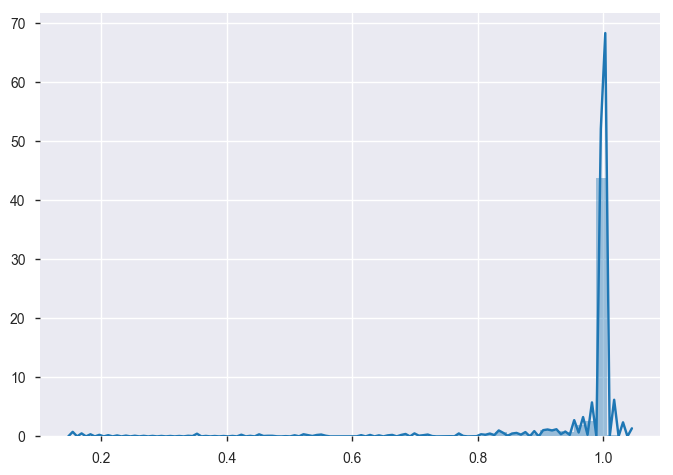

In [304]:
sum_to_one = df['OneBidRate'] + df['EffCompRate']
sns.distplot(sum_to_one)

It seems that not every value record sums to one, indicating some data quality issues. Let's inspect further by rounding each sum to the nearest tenth.

In [305]:
sum_to_one.round(decimals = 1).value_counts()

1.0    662
0.9     49
0.8     20
0.7     11
0.5      9
0.6      5
0.4      3
0.2      1
0.3      1
dtype: int64

In [306]:
no_sum_to_one = sum_to_one.round(decimals = 1).value_counts().sum() - 662
n_records = sum_to_one.round(decimals = 1).value_counts().sum()
print(f"{no_sum_to_one} of {n_records} records do not sum to one.")

99 of 761 records do not sum to one.


A lot of the records to do not sum to one as they should. We should either drop these observations from the analysis or fit models using probabilistic (e.g. bootstrap) methods. 

Another data quality issue we could check is whether or not $OneBidDollars + EffCompDollars = CompetedDollars$

In [307]:
competed_dollars = data1['CompetedDollars']
one_bid_dollars = data1['OneBidDollars']
eff_comp_dollars = data1['EffCompDollars']
actual_competed_dollars = one_bid_dollars + eff_comp_dollars
dif = competed_dollars - actual_competed_dollars
dif.abs().round().describe()

count    7.610000e+02
mean     4.931484e+07
std      3.129912e+08
min      0.000000e+00
25%      0.000000e+00
50%      3.182300e+04
75%      1.986108e+06
max      5.732543e+09
dtype: float64

The above finding is also alarming, suggesting that there are serious data quality issues at play here. Nevertheless, we'll proceed to fit a model for documentation purposes.

# Panel OLS
Despite the data quality issues identified above, here we'll fit a panel least sqaures model using fixed effects for both time and entities. This recreates the original analysis.

In [308]:
design_df = df.copy(deep = True)
design_df['NotCompRate_shift'] = design_df['NotCompRate'].shift(1)
design_df = design_df[design_df['FiscalYear'] != 2014]
year = pd.Categorical(design_df.FiscalYear)
design_df = design_df.set_index(['unique_name','FiscalYear'])
design_df['FiscalYear'] = year

In [310]:
exog_cols = ['SdbRate','OneBidRate','NotCompRate_shift']
exog = sm.add_constant(design_df[exog_cols])
model = PanelOLS(design_df.EffCompRate,
                 exog,
                 entity_effects = True,
                 time_effects = True).fit()

print(model)

                          PanelOLS Estimation Summary                           
Dep. Variable:            EffCompRate   R-squared:                        0.5169
Estimator:                   PanelOLS   R-squared (Between):              0.8956
No. Observations:                 608   R-squared (Within):               0.4587
Date:                Tue, May 14 2019   R-squared (Overall):              0.7648
Time:                        10:17:34   Log-likelihood                    743.60
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      157.28
Entities:                         161   P-value                           0.0000
Avg Obs:                       3.7764   Distribution:                   F(3,441)
Min Obs:                       1.0000                                           
Max Obs:                       4.0000   F-statistic (robust):             157.28
                            

/Users/charlessmcallister/.local/share/virtualenvs/contracting-hypotheses-Uo7sPNaA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


## Interpretation
Above, we notice a few issues:

1. We have 161 entities whereas the original analysis had 165. We're not sure what those extra 4 observations are.
2. All of our coefficient estimates differ from those originally found. That could be due to either the 4 missing observations, but it could also be due to the fixed effects we've included.

# Data Validity Simulations
Here we'll randomly generate data such that the OneBidRate does sum to one when added to the EffCompRate. We'll do this a couple thousand times, generating the same model as specified above. For each fit, we'll save the coeffecient parameter estimates and then perform some summary statistics on them to get a measure of the vagaries introduced by our poor data. 

In [311]:
exog_cols = ['SdbRate','OneBidRate','NotCompRate_shift']

sim_df = design_df.copy(deep = True)
sum_to_one = sim_df['OneBidRate'] + sim_df['EffCompRate']
sim_df['sums_to_one'] = sum_to_one.round(decimals = 1) >= 1
sim_df = sim_df.drop(labels = ['FiscalYear'], axis = 1)
#reset index due to duplciate contracting_agency and fiscal year combinations
#(bad for resetting individual cell values)
sim_df = sim_df.reset_index()
indices_to_adjust = sim_df.index[sim_df['sums_to_one'] == False].tolist()

params = []
for i in range(1000):
    #create deep copy of sim_df so we're not reassigning values in place
    temp_df = sim_df.copy(deep = True)
    for ix in indices_to_adjust:
        #get the values to adjust
        one_bid_rate = sim_df.at[ix, 'OneBidRate']
        eff_comp_rate = sim_df.at[ix, 'EffCompRate']
        #get get the difference from one. This is the amount we'll randomly fill
        diff = 1 - (one_bid_rate + eff_comp_rate)
        #randomly choose a number between 0 and the diff
        rand = random.uniform(0,diff)
        diff_rand = diff - rand
        #reassign these random filler values to the temp_df. This makes the two sum to one now
        temp_df.at[ix, 'OneBidRate'] += rand
        temp_df.at[ix, 'EffCompRate'] += diff_rand

    #restructure temp_df so we can fit a model
    year = pd.Categorical(temp_df.FiscalYear)
    temp_df = temp_df.set_index(['unique_name','FiscalYear'])
    temp_df['FiscalYear'] = year
    temp_df['NotCompRate_shift'] = temp_df['NotCompRate'].shift(1)
    temp_df = temp_df[temp_df['FiscalYear'] != 2014]
    #fit the model
    exog = sm.add_constant(temp_df[exog_cols])
    temp_model = PanelOLS(temp_df.EffCompRate,
                          exog,
                          entity_effects = True,
                          time_effects = True).fit()
    temp_params = temp_model.params
    params.append(pd.DataFrame(temp_params).transpose())
params_df = pd.concat(params)
#get original model params 
original_params = pd.DataFrame(model.params).transpose()

/Users/charlessmcallister/.local/share/virtualenvs/contracting-hypotheses-Uo7sPNaA/lib/python3.7/site-packages/linearmodels/utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


Now that we've got the estimated coefficients from 1,000 different simulations, we'll construct some 95% confidence intervals for each one and then see if the model's orginal parameteres fall within these ranges.

In [312]:
def get_ci(data, confidence = 0.95):
    n = len(data)
    m = mean(data)
    std_err = sem(data)
    h = std_err * t.ppf((1 + confidence) / 2, n - 1)
    start = m - h
    end = m + h
    
    return start, end

In [313]:
print(original_params, end = "\n\n")
for col in params_df.columns:
    col_values = params_df[col]
    start, end = get_ci(col_values)
    print(f"The 95% CI for {col} is {start:.4f} to {end:.4f}")

              const   SdbRate  OneBidRate  NotCompRate_shift
parameter  0.912394 -0.096236   -0.781734           0.026213

The 95% CI for const is 0.9945 to 0.9945
The 95% CI for SdbRate is -0.0034 to -0.0033
The 95% CI for OneBidRate is -0.9922 to -0.9921
The 95% CI for NotCompRate_shift is 0.0028 to 0.0028


As we can see, the original estimates do not fall within the 95% CIs. Although the signs are the same, we could have surmised as much without ever fitting a model given the definitions of each variable.

# Summary
There are three main issues with this analysis:

1. Inability to replicate the original analysis<br>
>We have been unable to replicate the analysis in both the estimated coeffecients and the number of observations.  
We've also been assuming that the model controlled for entity and time fixed effects. Theses issues need to be clarified.

1. Invalid Data<br>
>The simulations above demonstrated the bias introduced by the invalid OneBidRate and EffCompRate values. A recommended solution would be to drop records where the OneBidRate and EffCompRate do not sum to one. However, this might vastly reduce the number of observations and then undermine the analysis.

2. Model Specification<br>
>A common denominator for the IV (EffCompRate) and one of the DVs (OneBidRate) suggests that we'd be able to re-write the regression equation with the common denomonitor factored out as a separate term on the right-hand side of the equation. If we were to do this, we could likely demonstrate that there is a correlation between OneBidRate and the error term, as the denominator common to both this IV and the DV has been absorbed by the error term. This essentially renders the relationship between that IV and the DV as definitionally spurious.